In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)

#torch.backends.cudnn.benchmark=True

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data')
PATH_TRN = PATH/'train/imagenet/n01608432'

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

## Style match

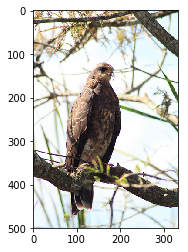

In [5]:
img_fn = PATH_TRN/'n01608432_27776.JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [6]:
img.shape

(500, 333, 3)

In [7]:
sz=512

In [8]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 512, 512)

In [9]:
os.listdir(PATH/'style')

['abstract.jpg',
 'Beautiful-Colors-stones.jpg',
 'Beautiful-Colors.jpg',
 'impressionism',
 'vaporwave']

In [49]:
style_fn = Path(PATH/'style'/'impressionism'/'original'/'9. the-starry-night-1889-vincent-van-gogh-post-impressionism.jpg')

In [50]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1591, 2000, 3), (500, 333, 3))

In [51]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [52]:
style = scale_match(img, style_img)

((499, 333, 3), (500, 333, 3))

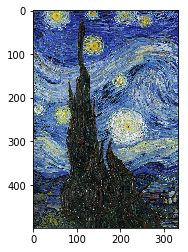

In [53]:
plt.imshow(style)
style.shape, img.shape

In [54]:
def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        if IS_TORCH_04: x = Variable(T(x), requires_grad=requires_grad)
        #if IS_TORCH_04: x = to_gpu(torch.tensor(x, requires_grad=requires_grad))
        else:           x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

In [55]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = create_variable(val_tfms(opt_img/2)[None], volatile=False, requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [56]:
opt_img_v, optimizer = get_opt()

In [57]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [58]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [59]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [60]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 512, 512]),
 torch.Size([1, 128, 256, 256]),
 torch.Size([1, 256, 128, 128]),
 torch.Size([1, 512, 64, 64]),
 torch.Size([1, 512, 32, 32])]

In [61]:
style_tfm = val_tfms(style_img)

In [62]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 512, 512]),
 torch.Size([1, 128, 256, 256]),
 torch.Size([1, 256, 128, 128]),
 torch.Size([1, 512, 64, 64]),
 torch.Size([1, 512, 32, 32])]

In [63]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [64]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [65]:
max_iter = 2000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [66]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [67]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 100, loss: 280.88189697265625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 200, loss: 113.20712280273438


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 300, loss: 58.17802810668945


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 400, loss: 31.414058685302734


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 500, loss: 17.077495574951172


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 600, loss: 9.561247825622559


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 700, loss: 5.893185615539551


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 800, loss: 4.087094306945801


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 900, loss: 3.1189894676208496


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1000, loss: 2.562276601791382


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1100, loss: 2.222771167755127


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1200, loss: 1.998889446258545


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1300, loss: 1.8381264209747314


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1400, loss: 1.7154070138931274


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1500, loss: 1.6214268207550049


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1600, loss: 1.545793890953064


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1700, loss: 1.4827618598937988


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1800, loss: 1.4303998947143555


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1900, loss: 1.3860127925872803


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 2000, loss: 1.3476933240890503


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


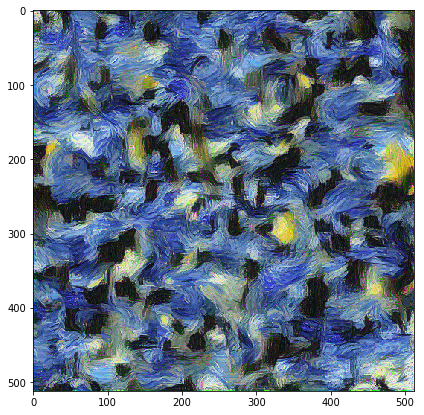

In [68]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [69]:
for sf in sfs: sf.close()

## Style transfer

In [70]:
def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        if IS_TORCH_04: x = Variable(T(x), requires_grad=requires_grad)
        #if IS_TORCH_04: x = to_gpu(torch.tensor(x, requires_grad=requires_grad))
        else:           x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

In [71]:
opt_img_v, optimizer = get_opt()

In [72]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [73]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*20000000
    style_loss = sum(losses)
    #print(f'style_loss: {str(style_loss)},  target_loss: {str(cnt_loss)}')
    return cnt_loss + style_loss

In [74]:
max_iter = 2000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [75]:
def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        #if IS_TORCH_04: x = Variable(T(x), requires_grad=requires_grad)
        if IS_TORCH_04: x = to_gpu(torch.tensor(x, requires_grad=requires_grad))
        else:           x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

In [76]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 100, loss: 12857.9658203125


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 200, loss: 6250.0751953125


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 300, loss: 4607.11376953125


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 400, loss: 3847.066162109375


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 500, loss: 3393.709716796875


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 600, loss: 3089.413818359375


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 700, loss: 2870.57666015625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 800, loss: 2704.84716796875


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 900, loss: 2574.388427734375


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1000, loss: 2463.758056640625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1100, loss: 2371.5244140625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1200, loss: 2294.09765625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1300, loss: 2228.2255859375


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1400, loss: 2169.75244140625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1500, loss: 2119.4384765625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1600, loss: 2075.244140625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1700, loss: 2035.4996337890625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1800, loss: 1998.974365234375


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 1900, loss: 1965.6412353515625


C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Iteration: 2000, loss: 1932.761474609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


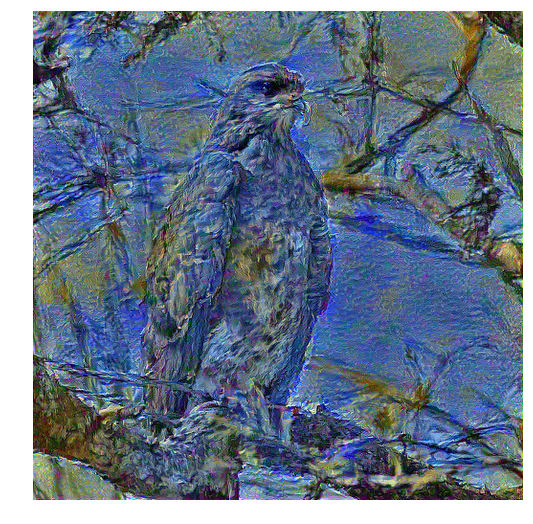

In [77]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [78]:
for sf in sfs: sf.close()